In [1]:
import time
from math import ceil
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.tensorboard
import yaml
from sirentv.utils import WeightedL2Loss
from sirentv.waveform import BatchedLightSimulation, mod0_sampler
from slar.utils import CSVLogger
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange


In [2]:
class TimingDataset(Dataset):
    """A regular Tensor Dataset, with weights"""
    def __init__(self, inputs, outputs):
        self.inputs = torch.stack(inputs) if isinstance(inputs, list) else inputs
        self.outputs = torch.stack(outputs) if isinstance(outputs, list) else outputs

        self.weights = torch.abs(self.outputs)*1e10
        self.weights = torch.clamp(self.weights, min=self.weights[self.weights!=0].min())
        assert self.inputs.shape[0] == self.outputs.shape[0], f"inputs and outputs must have the same number of batches, got {self.inputs.shape[0]} and {self.outputs.shape[0]}"

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx], self.weights[idx]

    def to(self, device):
        self.inputs = self.inputs.to(device)
        self.outputs = self.outputs.to(device)
        self.weights = self.weights.to(device)
        return self
    
class CSVTensorboardWriter(torch.utils.tensorboard.SummaryWriter):
    """A CSV writer that also optionally logs to tensorboard"""
    def __init__(self, *args, **kwargs):
        self.log_to_tensorboard = kwargs.pop('tensorboard', False)
        super().__init__(*args, **kwargs)
        self.csv_logger = CSVLogger(yaml.safe_load(f'''
        logger:
            dir_name: {self.get_logdir()}                                                                                 
        '''))

    def add_scalar(self, key, value, step):
        if self.log_to_tensorboard:
            super().add_scalar(key, value, step)
        self.csv_logger.record(['iter', key], [step, value])

    def flush(self):
        if self.log_to_tensorboard:
            super().flush()
        self.csv_logger.write()

    def close(self):
        if self.log_to_tensorboard:
            super().close()
        self.csv_logger.close()

In [5]:
device = torch.device('cuda:1')

def generate_dataset(nphoton, n_batch, batch_size, ndet=48):
    assert ndet <= 48, f"maximum number of channels is 48"

    assert n_batch % batch_size == 0, f"n_batch should be divisible by batch_size, got {n_batch} and {batch_size}"

    # Initialize the 'true' simulation with random initial parameters
    sim_true = BatchedLightSimulation(cfg="../templates/waveform_sim.yaml").to(device)

    # Sample the inputs
    inputs = mod0_sampler.batch_sample(nphoton=nphoton, nbatch=n_batch)


    with torch.no_grad():
        outputs_batch = []
        for i in trange(inputs.shape[0]//batch_size, desc="Generating dataset"):
            outputs_batch.append(sim_true(inputs[batch_size*i:batch_size*(i+1), :ndet].to(device), relax_cut=False))
        outputs = torch.concat(outputs_batch, dim=0)
        inputs = inputs[:, :ndet]

    dataset = TimingDataset(inputs, outputs).to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return sim_true, dataset, dataloader

sim_true, dataset, dataloader = generate_dataset(nphoton=16, n_batch=32, batch_size=8, ndet=48)

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe


Generating dataset: 100%|██████████| 4/4 [00:00<00:00, 20.67it/s]


Checking out dataset inputs and outputs, as well as the timing distribution we are sampling from.

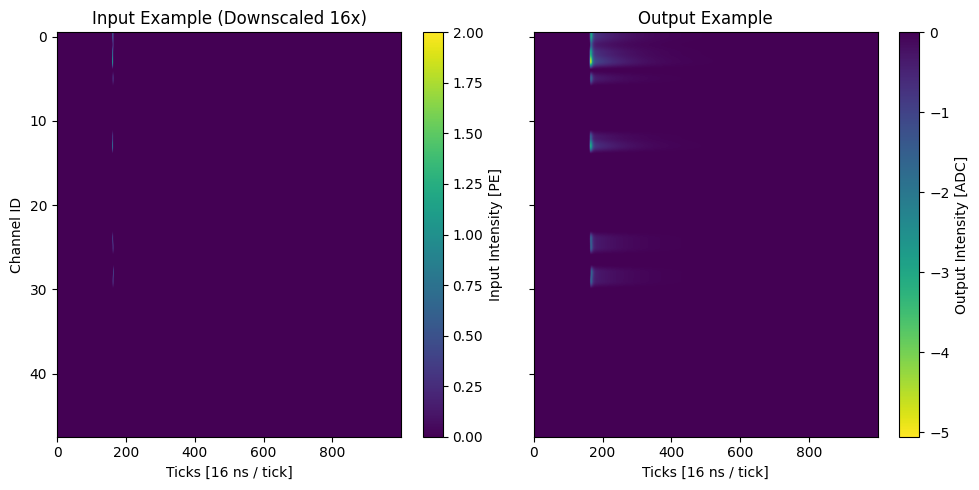

In [6]:
for input, output, weight in dataset:
    break

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

downsample_factor = int(input.size().numel() / output.size().numel())

input_downsampled = input.cpu().numpy().reshape(*output.shape, downsample_factor).sum(-1)

im0 = ax[0].imshow(input_downsampled, aspect='auto', cmap='viridis')
ax[0].set_title(f'Input Example (Downscaled {downsample_factor:.0f}x)')
fig.colorbar(im0, ax=ax[0], label='Input Intensity [PE]')

im1 = ax[1].imshow(output.cpu().numpy(), aspect='auto', cmap='viridis_r')
ax[1].set_title('Output Example')
fig.colorbar(im1, ax=ax[1], label='Output Intensity [ADC]')

for _ax in ax:
    _ax.set_xlabel(f'Ticks [{downsample_factor} ns / tick]')
ax[0].set_ylabel('Channel ID')

plt.tight_layout()
plt.show()

For each data entity containing 48 waveforms (i.e. the pictures above), 16 photon t0's are sampled from the distribution below, which was derived from a LUT.

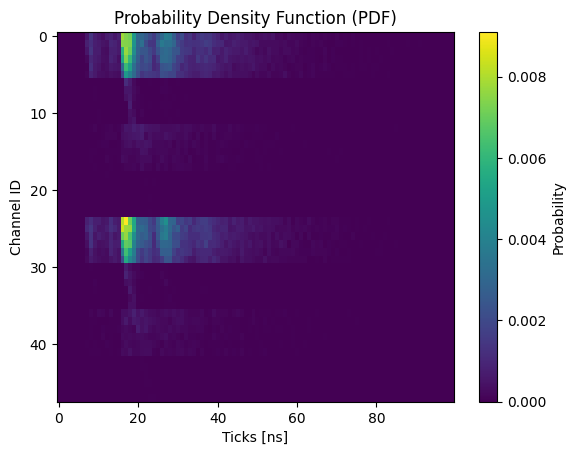

In [8]:
import numpy as np

pdf = np.diff(mod0_sampler.cdf, prepend=0).reshape(mod0_sampler.shape)
plt.imshow(pdf, aspect='auto', cmap='viridis')
plt.colorbar(label='Probability')
plt.title('Probability Density Function (PDF)')
plt.xlabel('Ticks [ns]')
plt.ylabel('Channel ID')
plt.show()

Now we set up model, optimizer, LR scheduler, and logger/writer.

In [9]:
NUM_EPOCHS = 1000
CLIP_NORM = 1
RELAX_CUT = 0 # include sigmoid relaxation for hard cuts. doesn't work well

criterion = WeightedL2Loss()
sim_train = BatchedLightSimulation(cfg="../templates/waveform_sim.yaml",).to(device)
optimizer = optim.Adam(sim_train.parameters(), lr=5e-2)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
writer = CSVTensorboardWriter(tensorboard=True)

for (name,param), (name_true, param_true) in zip(sim_train.named_parameters(), sim_true.named_parameters()):
        print(name,
                '\n\tinit:', round(param.item() * getattr(sim_train, f'nominal_{name}'), 2),
                '\n\ttrue:', round(param_true.item() * getattr(sim_true, f'nominal_{name}'), 2)
        )

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
[CSVLogger] output log directory: runs/Aug23_17-11-20_sdfampere004/version-00
[CSVLogger] recording a log every 1 steps
singlet_fraction_logit 
	init: -0.42 
	true: -1.23
log_tau_s 
	init: -2.04 
	true: -2.28
log_tau_t 
	init: 0.18 
	true: 0.14
log_light_oscillation_period 
	init: -0.89 
	true: -0.81
log_light_response_time 
	init: -1.15 
	true: -1.4
light_gain 
	init: -39.86 
	true: -44.97


Note that the singlet fraction is a sigmoid of a logit and the time constants are log-transformed. Also, note that the parameters that are being optimized are normalized to the nominal values so as to make each parameter O(1) so a single learning rate can be used for all parameters; to reconstruct the actual values, we need to transform them back by multiplying them by the nominal values.

In [10]:
true_tau_s = 10**(sim_true.log_tau_s.item() * sim_true.nominal_log_tau_s)
true_tau_t = 10**(sim_true.log_tau_t.item() * sim_true.nominal_log_tau_t)
true_singlet_fraction = torch.sigmoid(sim_true.singlet_fraction_logit.item() * torch.tensor(sim_true.nominal_singlet_fraction_logit))
true_light_oscillation_period = 10**(sim_true.log_light_oscillation_period.item() * sim_true.nominal_log_light_oscillation_period)
true_light_response_time = 10**(sim_true.log_light_response_time.item() * sim_true.nominal_log_light_response_time)
true_light_gain = sim_true.light_gain.item() * sim_true.nominal_light_gain

Now we set up the full training loop.

In [12]:
def get_param(sim, name):
    with torch.no_grad():
        return torch.tensor(getattr(sim, name).data.item() * getattr(sim, f'nominal_{name}'))

loss = torch.tensor(torch.inf, device=device)
for epoch in range(NUM_EPOCHS):
    times = []
    t0 = time.time()
    for it, (inputs, outputs, weights) in tqdm(enumerate(dataloader), desc=f"Epoch {epoch+1:02d} | Loss: {loss.item():.2e}", total=len(dataloader)):
        optimizer.zero_grad()
        outputs_train = sim_train(inputs, relax_cut=RELAX_CUT)
        loss = criterion(outputs_train, outputs, weights)
        loss.backward()

        if CLIP_NORM:
            torch.nn.utils.clip_grad_norm_(sim_train.parameters(), CLIP_NORM)

        optimizer.step()
        times.append(time.time() - t0)
        t0 = time.time()

        with torch.no_grad():
            tau_s = 10**get_param(sim_train, 'log_tau_s')
            tau_t = 10**get_param(sim_train, 'log_tau_t')
            singlet_fraction = torch.sigmoid(get_param(sim_train, 'singlet_fraction_logit'))
            light_oscillation_period = 10**get_param(sim_train, 'log_light_oscillation_period')
            light_response_time = 10**get_param(sim_train, 'log_light_response_time')
            light_gain = get_param(sim_train, 'light_gain')

            # get gradients
            grad_tau_s = abs(sim_train.log_tau_s.grad.item())
            grad_tau_t = abs(sim_train.log_tau_t.grad.item())
            grad_singlet_fraction = abs(sim_train.singlet_fraction_logit.grad.item())
            grad_light_oscillation_period = abs(sim_train.log_light_oscillation_period.grad.item())
            grad_light_response_time = abs(sim_train.log_light_response_time.grad.item())
            grad_light_gain = abs(sim_train.light_gain.grad.item())

        curr_step = (epoch * len(dataloader) + it) / len(dataloader)
        writer.add_scalar('train/loss', loss.item(), curr_step)
        writer.add_scalar('train/time', times[-1], curr_step)
        writer.add_scalar('train/tau_s', tau_s, curr_step)
        writer.add_scalar('train/tau_t', tau_t, curr_step)
        writer.add_scalar('train/singlet_fraction', singlet_fraction, curr_step)
        writer.add_scalar('train/light_oscillation_period', light_oscillation_period, curr_step)
        writer.add_scalar('train/light_response_time', light_response_time, curr_step)
        writer.add_scalar('train/light_gain', light_gain, curr_step)

        writer.add_scalar('eval/true_tau_s', true_tau_s, curr_step)
        writer.add_scalar('eval/true_tau_t', true_tau_t, curr_step)
        writer.add_scalar('eval/true_singlet_fraction', true_singlet_fraction, curr_step)
        writer.add_scalar('eval/true_light_oscillation_period', true_light_oscillation_period, curr_step)
        writer.add_scalar('eval/true_light_response_time', true_light_response_time, curr_step)
        writer.add_scalar('eval/true_light_gain', true_light_gain, curr_step)

        writer.add_scalar('eval/grad_tau_s', grad_tau_s, curr_step)
        writer.add_scalar('eval/grad_tau_t', grad_tau_t, curr_step)
        writer.add_scalar('eval/grad_singlet_fraction', grad_singlet_fraction, curr_step)
        writer.add_scalar('eval/grad_light_oscillation_period', grad_light_oscillation_period, curr_step)
        writer.add_scalar('eval/grad_light_response_time', grad_light_response_time, curr_step)
        writer.add_scalar('eval/grad_light_gain', grad_light_gain, curr_step)
        writer.flush()

    lr_scheduler.step()

    # print(f"Epoch {epoch+1}, Loss: {loss.item():.2e}")
writer.close()

Epoch 01 | Loss: inf: 100%|██████████| 4/4 [00:00<00:00, 14.55it/s]
Epoch 02 | Loss: 5.08e+06: 100%|██████████| 4/4 [00:00<00:00, 21.10it/s]
Epoch 03 | Loss: 5.12e+06: 100%|██████████| 4/4 [00:00<00:00, 21.28it/s]
Epoch 04 | Loss: 3.47e+06: 100%|██████████| 4/4 [00:00<00:00, 20.75it/s]
Epoch 05 | Loss: 3.50e+06: 100%|██████████| 4/4 [00:00<00:00, 21.53it/s]
Epoch 06 | Loss: 2.00e+06: 100%|██████████| 4/4 [00:00<00:00, 21.78it/s]
Epoch 07 | Loss: 1.28e+06: 100%|██████████| 4/4 [00:00<00:00, 19.92it/s]
Epoch 08 | Loss: 1.58e+06: 100%|██████████| 4/4 [00:00<00:00, 20.61it/s]
Epoch 09 | Loss: 9.57e+05: 100%|██████████| 4/4 [00:00<00:00, 20.20it/s]
Epoch 10 | Loss: 9.05e+05: 100%|██████████| 4/4 [00:00<00:00, 20.22it/s]
Epoch 11 | Loss: 7.15e+05: 100%|██████████| 4/4 [00:00<00:00, 21.64it/s]
Epoch 12 | Loss: 6.23e+05: 100%|██████████| 4/4 [00:00<00:00, 20.16it/s]
Epoch 13 | Loss: 4.85e+05: 100%|██████████| 4/4 [00:00<00:00, 20.65it/s]
Epoch 14 | Loss: 2.79e+05: 100%|██████████| 4/4 [00:00<0

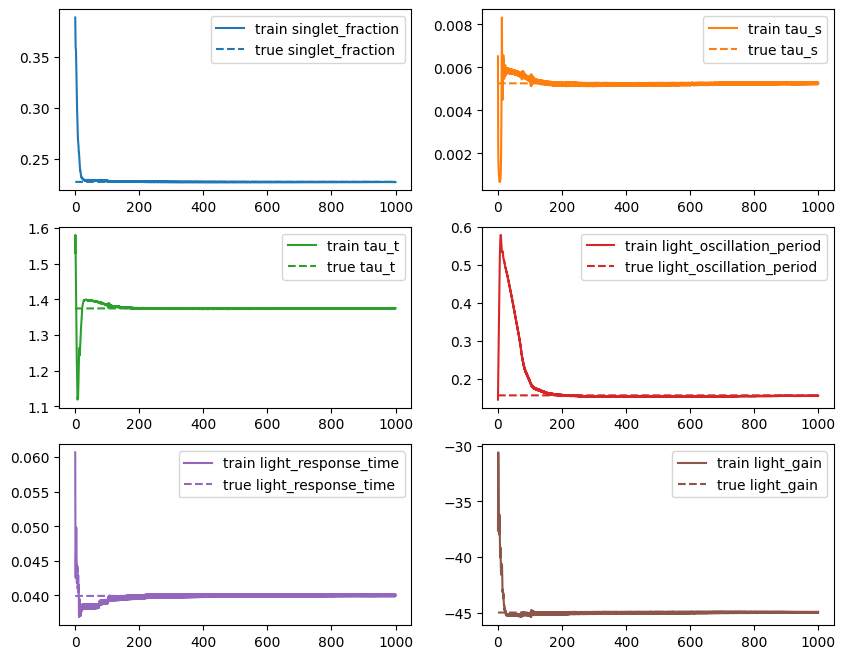

In [16]:
df = pd.read_csv(Path(writer.log_dir) / 'version-00' / 'log.csv')

pars = []
for i, (name, param) in enumerate(sim_train.named_parameters()):
    with torch.no_grad():
        value = param * getattr(sim_train, f'nominal_{name}')
        if 'log' in name:
            value = 10**value
        elif 'logit' in name:
            value = torch.sigmoid(value)
        value = value.item()
        pars.append(name.replace('log_', '').replace('_logit', ''))

fig, ax = plt.subplots(ceil(len(pars) / 2), 2, figsize=(10, 8))
for i, par in enumerate(pars):
    ax[i//2, i%2].plot(df['iter'], df['train/'+par], label=f"train {par}", c=f'C{i}')
    ax[i//2, i%2].plot(df['iter'], df['eval/true_'+par], label=f"true {par}", ls='--', c=f'C{i}')
    ax[i//2, i%2].legend()
plt.show()